Dataset size: (96, 9)


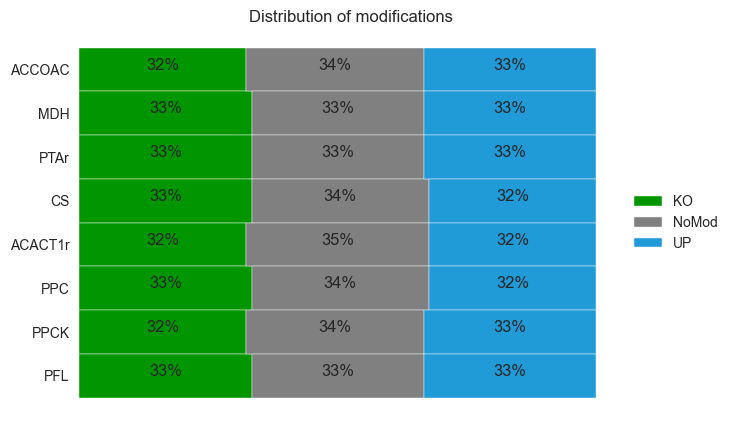

In [1]:
import sys

sys.path.append("../")

import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from src import plot_multiomics 

from straindesignxai.main import DataLoader

path = "../data/EDD_isoprenol_production.csv"
model_path = "../models/xgb_isoprenol.pkl"

input_var = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
response_var = ["Value"]

d = DataLoader(path, input_var, response_var)
plot_multiomics.plot_distribution_of_designs(d.df.drop('Value', axis=1))

In [2]:
# How many designs improve production over the WT
print(len(d.df[d.df['Value'] > d.df.loc['WT']['Value']]), 'designs out of', len(d.df), 'improve production over the WT')

11 designs out of 96 improve production over the WT


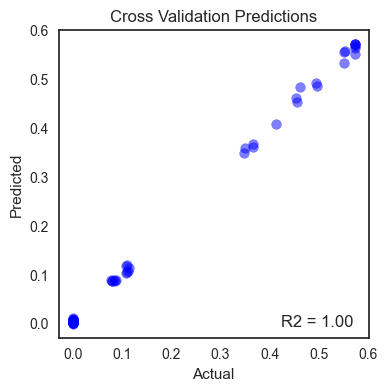

In [3]:
# load or train ml model
try:
    d.load_model(model_path)
except FileNotFoundError:
    d.train_xgb(n_iter=500)
    d.save_model(model_path)

d.plot_R2()

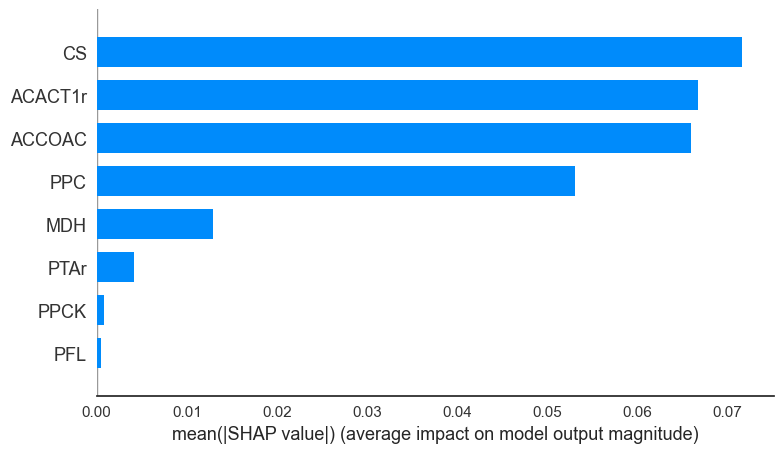

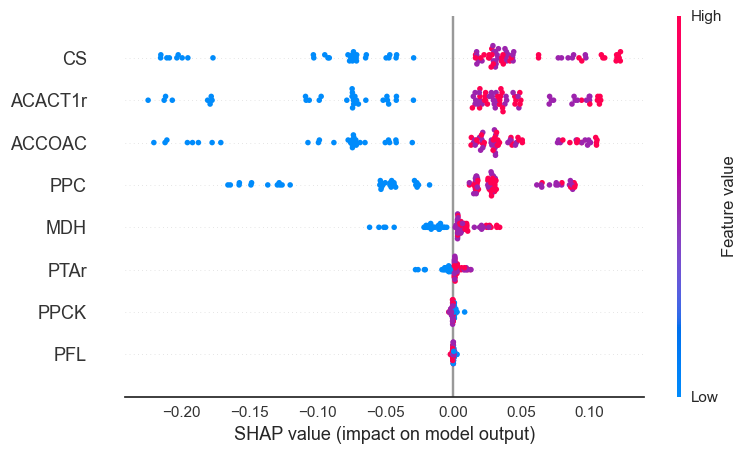

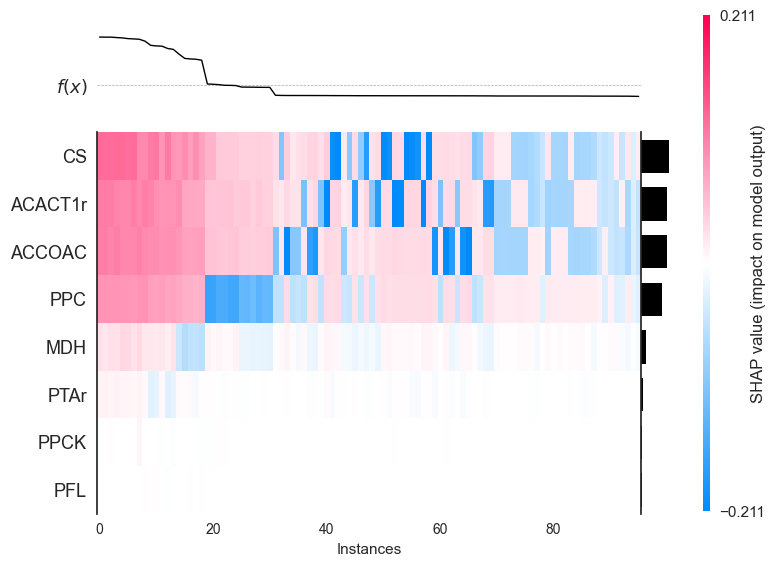

In [4]:
d.get_shap_values()

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

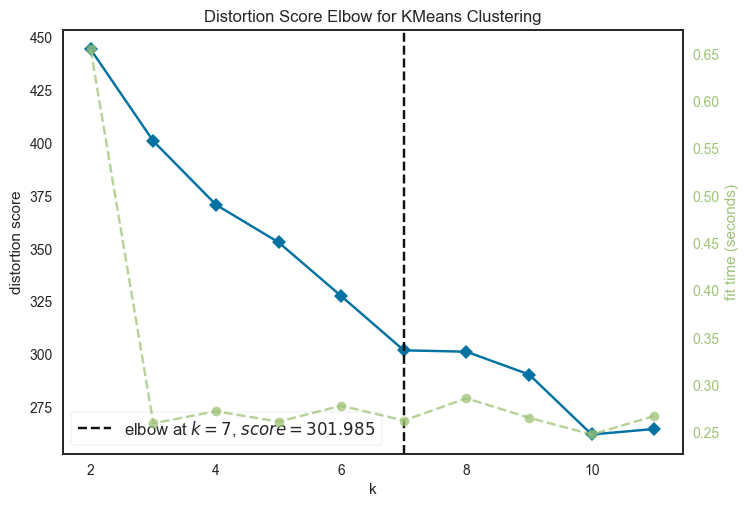

Optimal number of clusters: 7
Number of elements in each cluster: 
3    31
6    14
1    13
4    12
5    12
2     9
0     5
Name: cluster, dtype: int64


KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
cluster,,,,,,,,,
0,1.400000,0.000000,1.400000,1.400000,1.200000,1.200000,1.800000,1.200000,0.368718
1,1.538462,0.846154,1.153846,1.615385,0.000000,0.923077,1.153846,1.000000,0.000000
2,1.222222,1.333333,0.666667,0.000000,1.777778,1.777778,1.222222,0.666667,0.000000
3,0.612903,1.032258,1.032258,0.387097,0.612903,0.967742,0.967742,1.129032,0.000000
4,1.583333,0.750000,1.083333,1.166667,1.500000,0.000000,0.916667,1.000000,0.096391
5,0.000000,0.833333,0.833333,1.416667,1.416667,1.000000,0.916667,0.833333,0.000000
6,1.500000,1.571429,0.928571,1.714286,1.428571,1.357143,0.714286,1.000000,0.532511


In [5]:
d.supervised_clustering()
d.study_clusters()

In [9]:
d.study_clusters("most_frequent")

Number of elements in each cluster: 
3    31
6    14
1    13
4    12
5    12
2     9
0     5
Name: cluster, dtype: int64


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
cluster,,,,,,,,,
0,1.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,0.349196
1,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,0.000000
2,1.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0,0.000000
3,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.000000
4,2.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.080117
5,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.000000
6,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,0.552101


In [11]:
d.df[d.df['cluster'] == 6]

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value,cluster
Line Name,,,,,,,,,,
Strain 2,1.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.552101,6
Strain 4,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.551849,6
Strain 7,2.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,0.572648,6
Strain 17,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,0.495097,6
Strain 41,1.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,0.572648,6
Strain 46,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.572648,6
Strain 48,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.572648,6
Strain 49,1.0,2.0,1.0,2.0,2.0,1.0,0.0,1.0,0.572648,6
Strain 53,2.0,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.456256,6


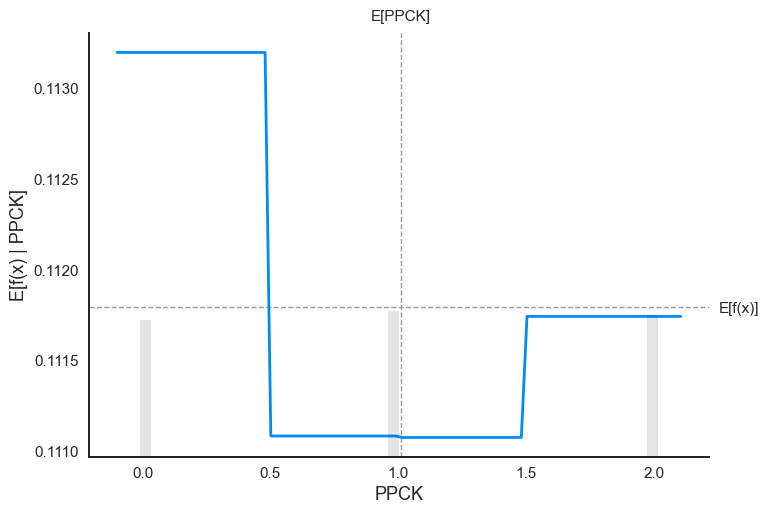

In [7]:
d.pdplot("PPCK")

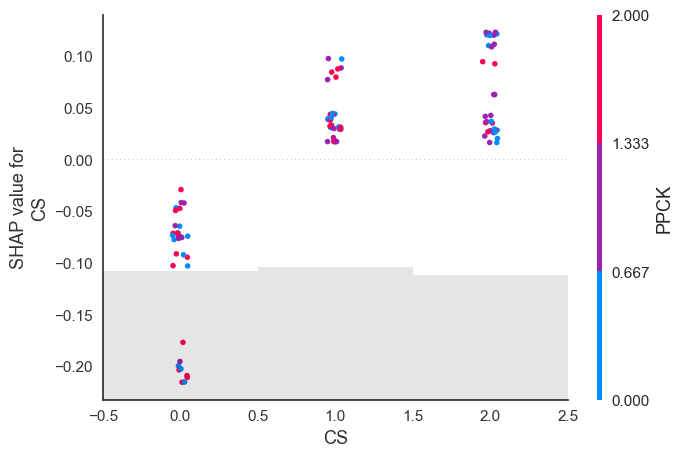

In [8]:
d.shap_scatter("CS", "PPCK")